In [71]:
import os
import sys
import time
import torch
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2 
import matplotlib
import scipy.stats as stats
import imageio.v2 as imageio
from torch import nn
from tqdm import trange
from utils import read_image, write_image, setup_seed
from copy import deepcopy
%matplotlib inline

os.environ['CUDA_VISIBLE_DEVICES']="1"

tonp = lambda x: x.cpu().detach().numpy()
mse_fn = lambda pred, gt: ((pred - gt)**2).mean()

def psnr_fn(pred, gt):
    mse = mse_fn(pred.clip(0, 1), gt)
    if isinstance(pred, torch.Tensor):
        return -10 * torch.log10(mse)
    return -10 * np.log10(mse)

setup_seed(3407)

#### **Models**

In [72]:
import math
from torch.nn import init

def init_weights(m, omega=1, c=1, is_first=False): # Default: Pytorch initialization
    if hasattr(m, 'weight'):
        fan_in = m.weight.size(-1)
        if is_first:
            bound = 1 / fan_in # SIREN
        else:
            bound = math.sqrt(c / fan_in) / omega
        init.uniform_(m.weight, -bound, bound)
    
def init_weights_kaiming(m):
    if hasattr(m, 'weight'):
        init.kaiming_normal_(m.weight, a=0.0, nonlinearity='relu', mode='fan_in')

def init_bias(m, k):
    if hasattr(m, 'bias'):
        init.uniform_(m.bias, -k, k)

'''Used for SIREN, FINER, Gauss, Wire, etc.'''
def init_weights_cond(init_method, linear, omega=1, c=1, is_first=False):
    init_method = init_method.lower()
    if init_method == 'sine':
        init_weights(linear, omega, 6, is_first)    # SIREN initialization
    ## Default: Pytorch initialization

def init_bias_cond(linear, fbs=None, is_first=True):
    if is_first and fbs != None:
        init_bias(linear, fbs)
    ## Default: Pytorch initialization

''' 
    FINER activation
    TODO: alphaType, alphaReqGrad
'''
def generate_alpha(x, alphaType=None, alphaReqGrad=False):
    """
    if alphaType == ...:
        return ...
    """
    with torch.no_grad():
        return torch.abs(x) + 1
    
def finer_activation(x, omega=1, alphaType=None, alphaReqGrad=False):
    return torch.sin(omega * generate_alpha(x, alphaType, alphaReqGrad) * x)


'''
    Gauss. & GF(FINER++Gauss.) activation
'''
def gauss_activation(x, scale):
    return torch.exp(-(scale*x)**2)

def gauss_finer_activation(x, scale, omega, alphaType=None, alphaReqGrad=False):
    return gauss_activation(finer_activation(x, omega, alphaType, alphaReqGrad), scale)

    
'''
    Wire & WF activation
'''
def wire_activation(x, scale, omega_w):
    return torch.exp(1j*omega_w*x - torch.abs(scale*x)**2)

def finer_activation_complex_sep_real_imag(x, omega=1):
    with torch.no_grad():
        alpha_real = torch.abs(x.real) + 1
        alpha_imag = torch.abs(x.imag) + 1
    x.real = x.real * alpha_real
    x.imag = x.imag * alpha_imag
    return torch.sin(omega * x)

def wire_finer_activation(x, scale, omega_w, omega, alphaType=None, alphaReqGrad=False):
    if x.is_complex():
        return wire_activation(finer_activation_complex_sep_real_imag(x, omega), scale, omega_w)
    else:
        return wire_activation(finer_activation(x, omega), scale, omega_w)


## FINER 
class FinerLayer(nn.Module):
    def __init__(self, in_features, out_features, bias=True, omega=30, 
                 is_first=False, is_last=False, 
                 init_method='sine', init_gain=1, fbs=None, hbs=None, 
                 alphaType=None, alphaReqGrad=False):
        super().__init__()
        self.omega = omega
        self.is_last = is_last ## no activation
        self.alphaType = alphaType
        self.alphaReqGrad = alphaReqGrad
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        
        # init weights
        init_weights_cond(init_method, self.linear, omega, init_gain, is_first)
        # init bias
        init_bias_cond(self.linear, fbs, is_first)
    
    def forward(self, input):
        wx_b = self.linear(input) 
        if not self.is_last:
            return finer_activation(wx_b, self.omega)
        return wx_b # is_last==True
      
class Finer(nn.Module):
    def __init__(self, in_features=2, out_features=3, hidden_layers=3, hidden_features=256, 
                 first_omega=30, hidden_omega=30, 
                 init_method='sine', init_gain=1, fbs=None, hbs=None, 
                 alphaType=None, alphaReqGrad=False):
        super().__init__()
        self.net = []
        self.net.append(FinerLayer(in_features, hidden_features, is_first=True, 
                                   omega=first_omega, 
                                   init_method=init_method, init_gain=init_gain, fbs=fbs,
                                   alphaType=alphaType, alphaReqGrad=alphaReqGrad))

        for i in range(hidden_layers):
            self.net.append(FinerLayer(hidden_features, hidden_features, 
                                       omega=hidden_omega, 
                                       init_method=init_method, init_gain=init_gain, hbs=hbs,
                                       alphaType=alphaType, alphaReqGrad=alphaReqGrad))

        self.net.append(FinerLayer(hidden_features, out_features, is_last=True, 
                                   omega=hidden_omega, 
                                   init_method=init_method, init_gain=init_gain, hbs=hbs)) # omega: For weight init
        self.net = nn.Sequential(*self.net)

    def forward(self, coords):
        return self.net(coords)



## SIREN 
class SineLayer(nn.Module):
    def __init__(self, in_features, out_features, bias=True, is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        self.init_weights()
    
    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features, 
                                             1 / self.in_features)    
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0,
                                             np.sqrt(6 / self.in_features) / self.omega_0)

    def forward(self, input):
        out = torch.sin(self.omega_0 * self.linear(input))
        return out

class Siren(nn.Module):
    def __init__(self, in_features=2, out_features=3, hidden_layers=3, hidden_features=256, first_omega_0=30, hidden_omega_0=30):
        super().__init__()
        self.net = []
        self.net.append(SineLayer(in_features, hidden_features, is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features, is_first=False, omega_0=hidden_omega_0))

        final_linear = nn.Linear(hidden_features, out_features)
        with torch.no_grad():
            final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0,
                                          np.sqrt(6 / hidden_features) / hidden_omega_0)
        self.net.append(final_linear)

        self.net = nn.Sequential(*self.net)
    
    def forward(self, coords):
        output = self.net(coords)
        return output



## WIRE
class ComplexGaborLayer(nn.Module):
    def __init__(self, in_features, out_features, bias=True, scale=10, omega_w=20, 
                 is_first=False, is_last=False, 
                 init_method='Pytorch', init_gain=1):
        super().__init__()
        self.scale = scale
        self.omega_w = omega_w
        self.is_last = is_last ## no activation
        dtype = torch.float if is_first else torch.cfloat
        self.linear = nn.Linear(in_features, out_features, bias=bias, dtype=dtype)

        # init weights
        init_weights_cond(init_method, self.linear, omega_w, init_gain, is_first)
        
    def forward(self, input):
        wx_b = self.linear(input) 
        if not self.is_last:
            return wire_activation(wx_b, self.scale, self.omega_w)
        return wx_b # is_last==True

class Wire(nn.Module):
    def __init__(self, in_features=2, out_features=3, hidden_layers=3, hidden_features=256, 
                 scale=10, omega_w=20,
                 init_method='sine', init_gain=1):
        super().__init__()
        hidden_features = int(hidden_features / np.sqrt(2))
        
        self.net = []
        self.net.append(ComplexGaborLayer(in_features, hidden_features, is_first=True, 
                                          scale=scale, omega_w=omega_w, 
                                          init_method=init_method, init_gain=init_gain))

        for i in range(hidden_layers):
            self.net.append(ComplexGaborLayer(hidden_features, hidden_features, 
                                              scale=scale, omega_w=omega_w, 
                                              init_method=init_method, init_gain=init_gain))

        self.net.append(ComplexGaborLayer(hidden_features, out_features, is_last=True, 
                                          scale=scale, omega_w=omega_w, 
                                          init_method=init_method, init_gain=init_gain)) # omega_w: For weight init
        self.net = nn.Sequential(*self.net)

    def forward(self, coords):
        output = self.net(coords)
        return output.real

 

## WFINER
class WFLayer(nn.Module):
    def __init__(self, in_features, out_features, bias=True, scale=10, omega_w=20, omega=1,
                 is_first=False, is_last=False, 
                 init_method='Pytorch', init_gain=1, fbs=None, hbs=None,
                 alphaType=None, alphaReqGrad=False):
        super().__init__()
        self.scale = scale
        self.omega_w = omega_w
        self.omega = omega
        self.is_last = is_last ## no activation
        dtype = torch.float if is_first else torch.cfloat
        self.linear = nn.Linear(in_features, out_features, bias=bias, dtype=dtype)
        
        # init weights
        init_weights_cond(init_method, self.linear, omega*omega_w, init_gain, is_first)
        
        # init bias 
        init_bias_cond(self.linear, fbs, is_first)
        
    def forward(self, input):
        wx_b = self.linear(input) 
        if not self.is_last:
            return wire_finer_activation(wx_b, self.scale, self.omega_w, self.omega)
        return wx_b # is_last==True

class WF(nn.Module):
    def __init__(self, in_features=2, out_features=3, hidden_layers=3, hidden_features=256, 
                 scale=10, omega_w=20, omega=1,
                 init_method='Pytorch', init_gain=1, fbs=None, hbs=None, 
                 alphaType=None, alphaReqGrad=False):
        super().__init__()
        hidden_features = int(hidden_features / np.sqrt(2))
        
        self.net = []
        self.net.append(WFLayer(in_features, hidden_features, is_first=True,
                                    omega=omega, scale=scale, omega_w=omega_w, 
                                    init_method=init_method, init_gain=init_gain, fbs=fbs,
                                    alphaType=alphaType, alphaReqGrad=alphaReqGrad))

        for i in range(hidden_layers):
            self.net.append(WFLayer(hidden_features, hidden_features, 
                                        omega=omega, scale=scale, omega_w=omega_w,
                                        init_method=init_method, init_gain=init_gain, hbs=hbs,
                                        alphaType=alphaType, alphaReqGrad=alphaReqGrad))

        self.net.append(WFLayer(hidden_features, out_features, is_last=True, 
                                    omega=omega, scale=scale, omega_w=omega_w,
                                    init_method=init_method, init_gain=init_gain, hbs=hbs)) # omega: For weight init
        self.net = nn.Sequential(*self.net)

    def forward(self, coords):
        output = self.net(coords)
        return output.real



## Gauss
class GaussLayer(nn.Module):
    def __init__(self, in_features, out_features, bias=True, scale=30.0,
                 is_first=False, is_last=False,
                 init_method='Pytorch', init_gain=1):
        super().__init__()
        self.scale = scale
        self.is_last = is_last
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        
        # init weights
        init_weights_cond(init_method, self.linear, None, init_gain, is_first)
    
    def forward(self, input):
        wx_b = self.linear(input) 
        if not self.is_last:
            return gauss_activation(wx_b, self.scale)
        return wx_b # is_last==True
    
class Gauss(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, 
                 scale=30,
                 init_method='Pytorch', init_gain=1):
        super().__init__()
        self.net = []
        self.net.append(GaussLayer(in_features, hidden_features, is_first=True, 
                                   scale=scale,
                                   init_method=init_method, init_gain=init_gain))

        for i in range(hidden_layers):
            self.net.append(GaussLayer(hidden_features, hidden_features, 
                                       scale=scale,
                                       init_method=init_method, init_gain=init_gain))
            
        self.net.append(GaussLayer(hidden_features, out_features, is_last=True, 
                                   scale=scale,
                                   init_method=init_method, init_gain=init_gain))
        self.net = nn.Sequential(*self.net)
    
    def forward(self, coords):
        output = self.net(coords)
        return output



## GFINER: Gauss-Finer
class GFLayer(nn.Module):
    def __init__(self, in_features, out_features, bias=True, scale=3, omega=1,
                 is_first=False, is_last=False, 
                 init_method='Pytorch', init_gain=1, fbs=None, hbs=None,
                 alphaType=None, alphaReqGrad=False):
        super().__init__()
        self.scale = scale
        self.omega = omega
        self.is_last = is_last
        self.linear = nn.Linear(in_features, out_features, bias=bias)
                
        # init weights
        init_weights_cond(init_method, self.linear, omega, init_gain, is_first)
            
        # init bias 
        init_bias_cond(self.linear, fbs, is_first)
    
    def forward(self, input):
        wx_b = self.linear(input) 
        if not self.is_last:
            gauss_finer_activation(wx_b, self.scale, self.omega)
        return wx_b # is_last==True

class GF(nn.Module):
    def __init__(self, in_features, out_features, hidden_layers, hidden_features, 
                 scale=3, omega=1, 
                 init_method='Pytorch', init_gain=1, fbs=None, hbs=None, 
                 alphaType=None, alphaReqGrad=False):
        super().__init__()
        self.net = []
        self.net.append(GFLayer(in_features, hidden_features, is_first=True, 
                                scale=scale, omega=omega, 
                                init_method=init_method, init_gain=init_gain, fbs=fbs,
                                alphaType=alphaType, alphaReqGrad=alphaReqGrad))
        
        for i in range(hidden_layers):
            self.net.append(GFLayer(hidden_features, hidden_features, 
                                     scale=scale, omega=omega, 
                                     init_method=init_method, init_gain=init_gain, hbs=hbs,
                                     alphaType=alphaType, alphaReqGrad=alphaReqGrad))
         
        self.net.append(GFLayer(hidden_features, out_features, is_last=True, 
                                scale=scale, omega=omega, 
                                init_method=init_method, init_gain=init_gain, hbs=hbs)) # omega: For weight init
        self.net = nn.Sequential(*self.net)
    
    def forward(self, coords):
        output = self.net(coords)
        return output

#### **2D Image Fitting** 

In [73]:
# Image Fitting 
def train_image(model, coords, gt, loss_fn=mse_fn, lr=5e-4, num_epochs=2000, steps_til_summary=10, invnorm=lambda x:x):
    optimizer = torch.optim.Adam(lr=lr, params=model.parameters())
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda iter: 0.1 ** min(iter / num_epochs, 1))
        
    train_iter = []
    train_psnr = []
    total_time = 0
    for epoch in trange(1, num_epochs + 1):
        time_start = time.time()

        pred = model(coords)
        loss = loss_fn(pred, gt)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        torch.cuda.synchronize()
        total_time += time.time() - time_start
   
        if not epoch % steps_til_summary:
            with torch.no_grad():
                train_iter.append(epoch)
                train_psnr.append((psnr_fn(invnorm(model(coords)), invnorm(gt))).item())        
                
    with torch.no_grad():
        pred = invnorm(model(coords))
        
    ret_dict = {
        'train_iter': train_iter,
        'train_psnr': train_psnr,
        'pred': pred,
        # 'model_state': model.state_dict(),
    }
    return ret_dict

In [74]:
from easydict import EasyDict

default_cfg = EasyDict({
    # Data
    'imgid':                0, 
    'datadir':              'data/div2k/test_data/',
    'specific_img':         None,
    
    # Model
    'in_features':          2,
    'out_features':         3,
    'hidden_layers':        3,
    'hidden_features':      256,
    
    'model_type':           'Finer',        # GF, Gauss, Wire, WF, Finer, SIREN ...
    'first_omega':          30,             # sine
    'hidden_omega':         30,             # sine
    'omega':                5,              # used to control variable period (omega_finer)
    'scale':                1,              # used in GF, Wire
    'omega_w':              20,             # used in Wire
        
    'fbs':                  None,
    'hbs':                  None,           # To do
    'init_method':          'sine',         # sine, default: pytorch
    'init_gain':            1,              # sqrt(gain/N) 

    # Train
    'lr':                   5e-4,
    'num_epochs':           5000,
    'zero_mean':            True,
    ## Log 
    'logdir':               'logs/Finer/',
    'savename':             'test',
    'reuse':                True,           # use cached checkpoints
    'exp_suffix':           '',
    ## Visualization
    'return_results':       False,
    'show_image':           False,
    'print_expname':        True,
    'print_model':          False,
    'vis_result':           True,
    'vis_usefbs':           False
})

def imgid2path(imgid, datadir='data/div2k/test_data'):
    if datadir.find('div2k') != -1:
        path = os.path.join(datadir, '%02d.png'%(imgid))
    if datadir.find('kodak') != -1:
        path = os.path.join(datadir, 'kodim%02d.png'%(imgid))
    return path

def activation_xy(cfg, a=-1, b=1):
    x = torch.linspace(a, b, 100000)
    if cfg.vis_usefbs and cfg.fbs: 
        x0 = x + cfg.fbs
    else:
        x0 = x
    mtype = cfg.model_type.lower()
    if mtype == 'finer':
        y = finer_activation(x0, cfg.first_omega)
    elif mtype == 'siren':
        y = torch.sin(cfg.first_omega * x0)
    elif mtype == 'wire':
        y = wire_activation(x0, cfg.scale, cfg.omega_w)
    elif mtype == 'wf':
        y = wire_finer_activation(x0, cfg.scale, cfg.omega_w, cfg.omega)
    elif mtype == 'gauss':
        y = gauss_activation(x0, cfg.scale)
    elif mtype == 'gf':
        y = gauss_finer_activation(x0, cfg.scale, cfg.omega)
    return x, y

def generate_expname(cfg):
    expname = \
        f"imid[{cfg.imgid}]_{cfg.model_type}_{cfg.hidden_layers}x{cfg.hidden_features}_" + \
        f"init[{cfg.init_method}]_fbs[{cfg.fbs}]_lr[{cfg.lr}]"
    #
    mtype = cfg.model_type.lower()
    if mtype == 'finer' or mtype == 'siren':    # first_omega, hidden_omega
        expname += f"_fw[{cfg.first_omega}]_hw[{cfg.hidden_omega}]"
    elif mtype == 'gauss' or mtype == 'gf':     # omega, scale
        expname += f"_omega[{cfg.omega}]_scale[{cfg.scale}]"
    elif mtype == 'wire' or mtype == 'wf':
        expname += f"_omega[{cfg.omega}]_scale[{cfg.scale}]_omegaw[{cfg.omega_w}]"
    return expname + cfg.exp_suffix

def get_model(cfg):
    mtype = cfg.model_type.lower()
    if mtype == 'finer':
        model = Finer(in_features=cfg.in_features, out_features=cfg.out_features, hidden_layers=cfg.hidden_layers, hidden_features=cfg.hidden_features,
                      first_omega=cfg.first_omega, hidden_omega=cfg.hidden_omega,
                      init_method=cfg.init_method, init_gain=cfg.init_gain, fbs=cfg.fbs)
    elif mtype == 'siren':
        model = Siren(in_features=cfg.in_features, out_features=cfg.out_features, hidden_layers=cfg.hidden_layers, hidden_features=cfg.hidden_features,
                      first_omega_0=cfg.first_omega, hidden_omega_0=cfg.hidden_omega)
    elif mtype == 'wire':
        model = Wire(in_features=cfg.in_features, out_features=cfg.out_features, hidden_layers=cfg.hidden_layers, hidden_features=cfg.hidden_features,
                     scale=cfg.scale, omega_w=cfg.omega_w,
                     init_method=cfg.init_method, init_gain=cfg.init_gain)
    elif mtype == 'wf':
        model = WF(in_features=cfg.in_features, out_features=cfg.out_features, hidden_layers=cfg.hidden_layers, hidden_features=cfg.hidden_features,
                   scale=cfg.scale, omega_w=cfg.omega_w, omega=cfg.omega,
                   init_method=cfg.init_method, init_gain=cfg.init_gain, fbs=cfg.fbs)
    elif mtype == 'gauss':
        model = Gauss(in_features=cfg.in_features, out_features=cfg.out_features, hidden_layers=cfg.hidden_layers, hidden_features=cfg.hidden_features,
                      scale=cfg.scale,
                      init_method=cfg.init_method, init_gain=cfg.init_gain)
    elif mtype == 'gf':
        model = GF(in_features=cfg.in_features, out_features=cfg.out_features, hidden_layers=cfg.hidden_layers, hidden_features=cfg.hidden_features,
                   scale=cfg.scale, omega=cfg.omega,
                   init_method=cfg.init_method, init_gain=cfg.init_gain, fbs=cfg.fbs)
    return model

def fitting_image_usecfg(cfg): # cfg: const
    # data
    if not cfg['zero_mean']:
        norm = lambda x : x
        invnorm = lambda x : x
    else:
        norm = lambda x : x*2-1
        invnorm = lambda x : x/2+0.5
        
    im_path = cfg.specific_img if cfg.specific_img is not None else imgid2path(cfg.imgid, cfg.datadir)
    im = read_image(im_path)
    if cfg['show_image']: plt.figure(figsize=(3, 3)); plt.imshow(im); plt.show();
    H, W = im.shape[:2]
    C = im.shape[2] if len(im.shape) == 3 else 1
    im = norm(im)

    # expname
    expname = generate_expname(cfg)
    if cfg['print_expname']: print(expname)
        
    # target
    im_gt = torch.tensor(im).reshape(H*W, C)

    # input
    coords = torch.stack(torch.meshgrid(torch.linspace(-1, 1, H), torch.linspace(-1, 1, W), indexing='ij'), dim=-1).reshape(-1, 2)

    # model 
    model = get_model(cfg)
    if cfg['print_model']: print(model)
    
    ## to gpu
    device = torch.device('cuda:0')
    im_gt = im_gt.to(device)
    coords = coords.to(device)
    model = model.to(device)

    # logdir 
    logdir = cfg['logdir']
    os.makedirs(logdir, exist_ok=True)
    
    # load cached results
    savepath = os.path.join(logdir, f"{cfg['savename']}.pt")
    cached_results = {} if not os.path.exists(savepath) else torch.load(savepath)
    
    # not in || in && not reuse
    if (expname not in cached_results) or ((expname in cached_results) and (not cfg['reuse'])):
        ret = train_image(model, coords, im_gt, loss_fn=mse_fn, lr=cfg.lr, num_epochs=cfg.num_epochs, steps_til_summary=10, invnorm=invnorm)
        cached_results[expname] = ret
        torch.save(cached_results, savepath)
  
    ## show: predicted image, psnr-iteration curve, activation curve
    if cfg['vis_result']:
        ret = cached_results[expname]
        plt.figure(figsize=(4*3,3))
        plt.subplot(1, 3, 1)
        plt.imshow(tonp(ret['pred'].reshape(H, W, C)).clip(0, 1)); plt.title('Pred')
        plt.subplot(1, 3, 2) 
        plt.plot(ret['train_iter'], ret['train_psnr']); plt.title('Train PSNR'); plt.xlabel('Iters'); plt.ylabel('PSNR (dB)')
        plt.text(ret['train_iter'][-1], ret['train_psnr'][-1], '%.2f'%ret['train_psnr'][-1])
        plt.subplot(1, 3, 3)
        x, y = activation_xy(cfg)
        plt.plot(x, y); plt.title('Activation');
        plt.show()
    
    return cached_results[expname] if cfg.return_results else cached_results[expname]['train_psnr'][-1] # All results or final psnr

In [75]:
''' Execute the above code '''

' Execute the above code '

##### **Activation Functions** 
- Sine
- FINER++(Sine)     
- Gauss.
- FINER++(Gauss.)   
- Wavelet
- FINER++(Wavelet)  

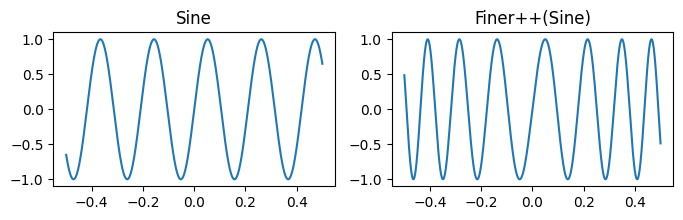

In [76]:
OMGEA = 30
bound = 0.5

## Sine Activation
cfg = deepcopy(default_cfg)
cfg.model_type = 'Siren'
cfg.first_omega = OMGEA
x0, y0 = activation_xy(cfg, -bound, bound)

## Finer++(Sine) Activation
cfg.model_type = 'Finer'
cfg.first_omega = OMGEA
x1, y1 = activation_xy(cfg, -bound, bound)

plt.figure(figsize=(8, 2))
plt.subplot(121); plt.plot(x0, y0); plt.title('Sine')  
plt.subplot(122); plt.plot(x1, y1); plt.title('Finer++(Sine)')
plt.show()

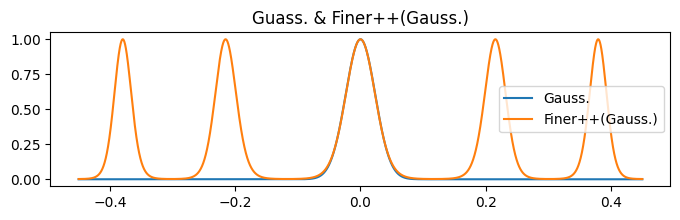

In [77]:
SCALE = 30 # ref: WIRE
bound = 0.45

## Gaussian Activation
cfg = deepcopy(default_cfg)
cfg.model_type = 'Gauss'
cfg.scale = SCALE
x0, y0 = activation_xy(cfg, -bound, bound)

## Finer++(Gaussian) Activation
cfg.model_type = 'GF'
cfg.omega = 12
cfg.scale = SCALE / cfg.omega
x1, y1 = activation_xy(cfg, -bound, bound)

plt.figure(figsize=(8, 2))
plt.plot(x0, y0, label='Gauss.')
plt.plot(x1, y1, label='Finer++(Gauss.)')
plt.legend()
plt.title('Guass. & Finer++(Gauss.)')
plt.show()

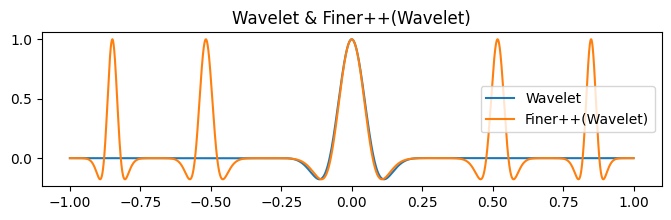

In [78]:
SCALE = 10 # ref: WIRE
OMGEAW = 20
bound = 1

## Wavelet Activation
cfg = deepcopy(default_cfg)
cfg.model_type = 'Wire'
cfg.scale = SCALE
cfg.omega_w = OMGEAW
x0, y0 = activation_xy(cfg, -bound, bound)

## Finer++(Wavelet) Activation
cfg.model_type = 'WF'
cfg.omega = 4
cfg.scale = SCALE / cfg.omega
cfg.omega_w = OMGEAW / cfg.omega
x1, y1 = activation_xy(cfg, -bound, bound)

plt.figure(figsize=(8, 2))
plt.plot(x0, y0.real, label='Wavelet')
plt.plot(x1, y1.real, label='Finer++(Wavelet)')
plt.legend()
plt.title('Wavelet & Finer++(Wavelet)')
plt.show()

##### Train: Sine


imid[1]_Siren_3x256_init[sine]_fbs[None]_lr[0.0005]_fw[30]_hw[30]


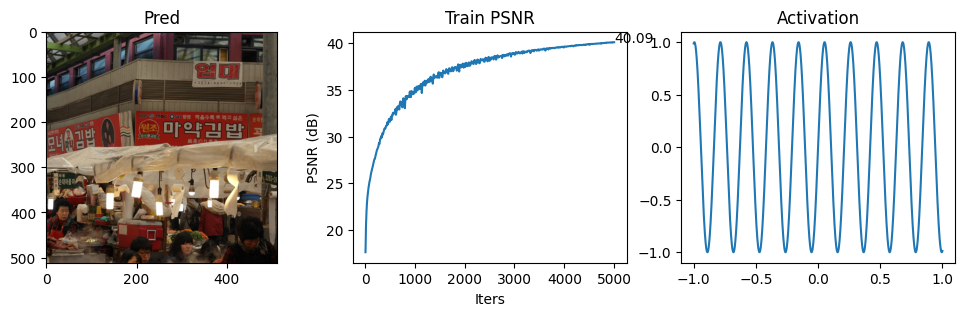

40.093292236328125

In [79]:
cfg = deepcopy(default_cfg)
cfg.model_type = 'Siren' 
# hparams
cfg.first_omega = 30
cfg.hidden_omega = 30
cfg.init_method = 'sine'
# log
cfg.logdir = f'logs/div2k/{cfg.model_type}'
# train
cfg.lr = 5e-4
cfg.reuse = True
# data
cfg.imgid = 1
cfg.datadir = 'data/div2k/test_data/'
# vis
cfg.print_expname = True
cfg.vis_result = True

fitting_image_usecfg(cfg)

##### Train: Finer++(Sine)


imid[1]_Finer_3x256_init[sine]_fbs[None]_lr[0.0005]_fw[30]_hw[30]


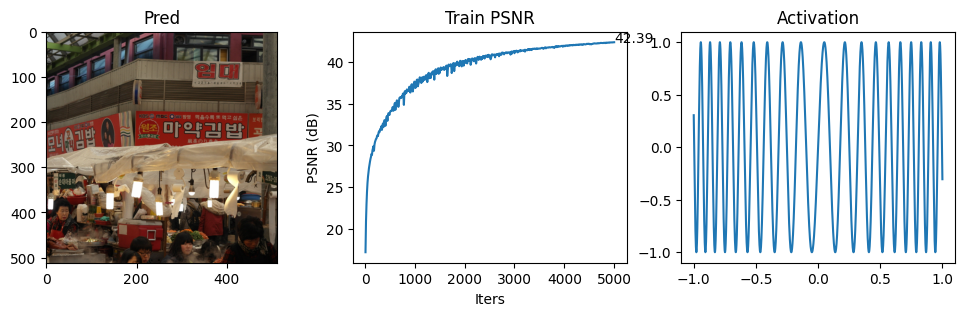

42.39179229736328

In [80]:
cfg = deepcopy(default_cfg)
cfg.model_type = 'Finer' 
# hparams
cfg.first_omega = 30
cfg.hidden_omega = 30
cfg.init_method = 'sine'
# log
cfg.logdir = f'logs/div2k/{cfg.model_type}'
# train
cfg.lr = 5e-4
cfg.reuse = True
# data
cfg.imgid = 1
cfg.datadir = 'data/div2k/test_data/'
# vis
cfg.print_expname = True
cfg.vis_result = True

fitting_image_usecfg(cfg)

##### Train: Gauss.


imid[1]_Gauss_3x256_init[Pytorch]_fbs[None]_lr[0.005]_omega[5]_scale[30]


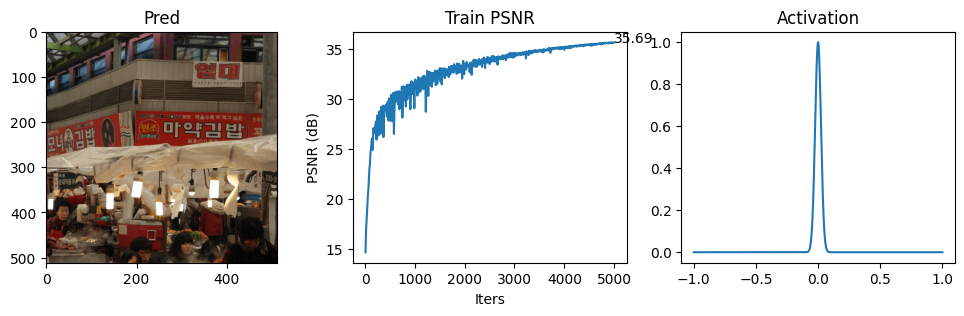

35.69071960449219

In [81]:
cfg = deepcopy(default_cfg)
cfg['model_type'] = 'Gauss' 
# hparams
cfg.scale = 30
cfg.init_method = 'Pytorch'
# log
cfg.logdir = f'logs/div2k/{cfg.model_type}'
# train
cfg.lr = 5e-3
cfg.reuse = True
# data
cfg.imgid = 1
cfg.datadir = 'data/div2k/test_data/'
# vis
cfg.print_expname = True
cfg.vis_result = True

fitting_image_usecfg(cfg)

##### Train: Finer++(Gauss.)


imid[1]_GF_3x256_init[sine]_fbs[1]_lr[0.001]_omega[10]_scale[3]


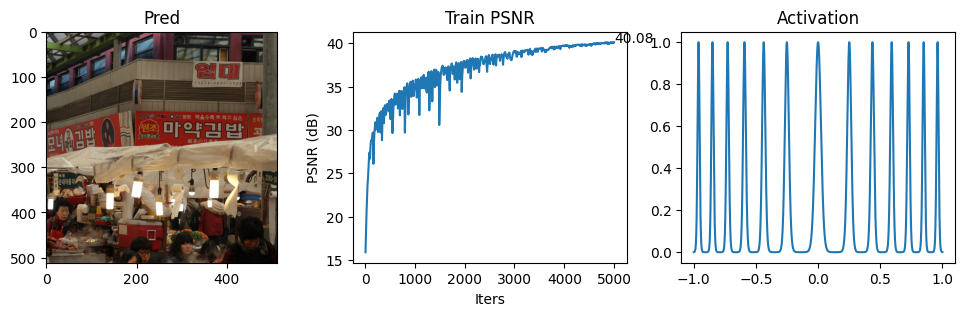

40.08439636230469

In [82]:
cfg = deepcopy(default_cfg)
cfg['model_type'] = 'GF' 
# hparams
cfg.omega = 10
cfg.scale = 3
cfg.init_method = 'sine'
cfg.fbs = 1
# log
cfg.logdir = f'logs/div2k/{cfg.model_type}'
# train
cfg.lr = 1e-3
cfg.reuse = True
# data
cfg.imgid = 1
cfg.datadir = 'data/div2k/test_data/'
# vis
cfg.print_expname = True
cfg.vis_result = True

fitting_image_usecfg(cfg)

##### Train: Wavelet

imid[1]_Wire_3x256_init[Pytorch]_fbs[None]_lr[0.005]_omega[5]_scale[10]_omegaw[20]


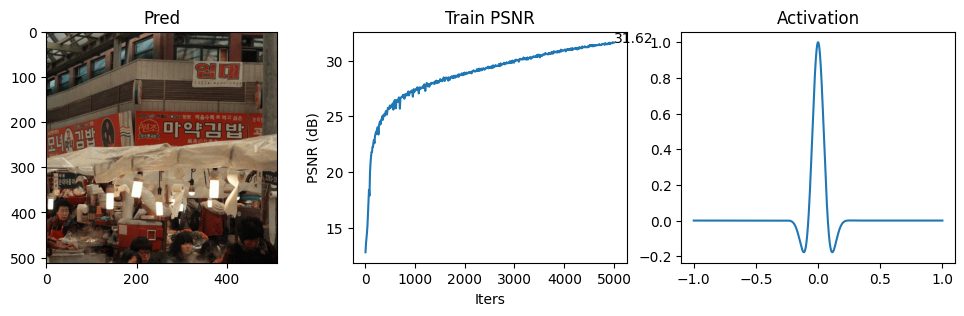

31.61796760559082

In [83]:
cfg = deepcopy(default_cfg)
cfg['model_type'] = 'Wire' 
# hparams
cfg.scale = 10
cfg.omega_w = 20
cfg.init_method = 'Pytorch'
# log
cfg.logdir = f'logs/div2k/{cfg.model_type}'
# train
cfg.lr = 5e-3
cfg.reuse = True
# data
cfg.imgid = 1
cfg.datadir = 'data/div2k/test_data/'
# vis
cfg.print_expname = True
cfg.vis_result = True

fitting_image_usecfg(cfg)

##### Train: Finer++(Wavelet)


imid[1]_WF_3x256_init[sine]_fbs[1]_lr[0.001]_omega[5]_scale[2]_omegaw[4]


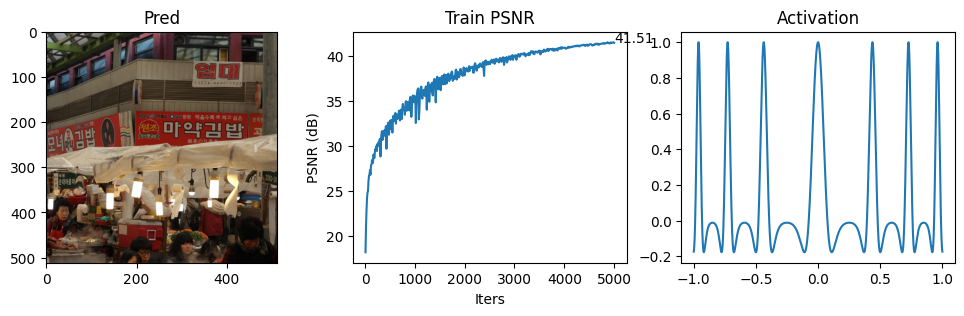

41.50877380371094

In [84]:
cfg = deepcopy(default_cfg)
cfg['model_type'] = 'WF' 
# hparams
cfg.scale = 2
cfg.omega_w = 4
cfg.omega = 5
cfg.init_method = 'sine'
cfg.fbs = 1
# log
cfg.logdir = f'logs/div2k/{cfg.model_type}'
# train
cfg.lr = 1e-3
cfg.reuse = True
# data
cfg.imgid = 1
cfg.datadir = 'data/div2k/test_data/'
# vis
cfg.print_expname = True
cfg.vis_result = True

fitting_image_usecfg(cfg)